In [1]:
import torch
import torchvision
from torch import nn, optim
from torchinfo import summary
from torchvision import datasets, transforms, utils, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np

import psutil
import sys
import os
from PIL import Image
from copy import deepcopy
from datetime import datetime
from os import makedirs
from os.path import join, isfile, isdir

import warnings
warnings.filterwarnings("ignore") 

# Basic configuration parameters used in EfficientNetV2 for compound scaling

In [2]:
config = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
    },
    "s": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
    },
    "m": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
    },
    "l": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
    },
}

# Base convolution block(BN and SiLU)

In [3]:
class BaseConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        groups=1,
        bias=False,
        bn=True,
        active=True,
    ) -> None:
        super(BaseConv, self).__init__()

        # base conv
        self.base_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=groups,
                bias=bias,
            ),
            nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
            nn.SiLU() if active else nn.Identity(),
        )

    def forward(self, x):
        return self.base_conv(x)

# SqueezeExcitation block

In [4]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction=24) -> None:
        super(SqueezeExcitation, self).__init__()

        # Squeeze And Excitation
        self.cofficient = nn.Sequential(
            # Squeeze
            nn.AdaptiveAvgPool2d(output_size=1),
            # Excitation
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.cofficient(x)

# MBConv block (MobileNet)

In [5]:
class MBConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        expand_ratio,
        kernel_size=3,
        stride=1,
        reduction=24,
        survival_prob=0.8,
    ) -> None:
        super(MBConv, self).__init__()

        # stride must be 1 or 2
        if not (1 <= stride <= 2):
            raise ValueError("illegal stride value")

        # check wether use residual
        self.use_residual = (in_channels == out_channels) and (stride == 1)

        # calculate padding and expanded channels
        padding = (kernel_size - 1) // 2
        self.survival_prob = survival_prob
        expanded_channels = in_channels * expand_ratio

        self.expand = nn.Sequential(
            nn.Identity()
            if expand_ratio == 1
            else BaseConv(
                in_channels=in_channels,
                out_channels=expanded_channels,
                kernel_size=1,
                padding=0,
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=expanded_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=expanded_channels,
            ),
            SqueezeExcitation(
                in_channels=expanded_channels, reduction=4 * expand_ratio
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=out_channels,
                kernel_size=1,
                padding=0,
                active=False,
            ),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, x):
        residual = x
        x = self.expand(x)

        if self.use_residual:
            x = self.stochastic_depth(x) + residual

        return x

# FusedMBConv block (for early stages)

In [6]:
class FusedMBConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        expand_ratio,
        kernel_size=3,
        stride=1,
        reduction=24,
        survival_prob=0.8,
    ) -> None:
        super(FusedMBConv, self).__init__()

        # stride must be 1 or 2
        if not (1 <= stride <= 2):
            raise ValueError("illegal stride value")

        # check wether use residual
        self.use_residual = (in_channels == out_channels) and (stride == 1)

        # calculate padding and expanded channels
        padding = (kernel_size - 1) // 2
        self.survival_prob = survival_prob
        expanded_channels = in_channels * expand_ratio

        self.expand = nn.Sequential(
            BaseConv(
                in_channels=in_channels,
                out_channels=expanded_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=out_channels,
                kernel_size=1,
                padding=0,
                active=False,
            ),
        )

        if expand_ratio == 1:
            self.expand = nn.Sequential(
                nn.Identity(),
                BaseConv(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=stride,
                    padding=1,
                ),
            )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, x):
        residual = x
        x = self.expand(x)

        if self.use_residual:
            x = self.stochastic_depth(x) + residual

        return x

# Creating stages

In [7]:
def mbconv4(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return MBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=4,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


def mbconv6(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return MBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=6,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


def fused_mbconv1(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return FusedMBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=1,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


def fused_mbconv4(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return FusedMBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=4,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]


def create_stage(
    in_channels,
    out_channels,
    num_layers,
    layer=mbconv6,
    kernel_size=3,
    stride=1,
    reduction=24,
    survival_prob=0.9,
):
    layers = [
        layer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            reduction=reduction,
            survival_prob=survival_prob,
        )
    ]

    layers += [
        layer(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            reduction=reduction,
            survival_prob=survival_prob,
        )
        for _ in range(num_layers - 1)
    ]

    return nn.Sequential(*layers)

# EfficientNetV2 block

In [8]:
class EfficientNetV2(nn.Module):
    def __init__(self, version="b0", num_classes=1000) -> None:
        super(EfficientNetV2, self).__init__()

        self.config = config[version]

        widths, depths, strides, convs = (
            self.config["widths"],
            self.config["depths"],
            self.config["strides"],
            self.config["convs"],
        )
        out_channels_size = self.config["output_conv_size"]

        stages = [BaseConv(in_channels=3, out_channels=widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(
                create_stage(
                    in_channels=widths[i],
                    out_channels=widths[i + 1],
                    num_layers=depths[i],
                    layer=layers_map[convs[i]],
                    stride=strides[i],
                    reduction=4 if i == 0 else 24,
                    survival_prob=0.9,
                )
            )

        self.efficient_net = nn.Sequential(
            *stages,
            BaseConv(
                in_channels=widths[-1],
                out_channels=out_channels_size,
                kernel_size=1,
                padding=0,
            ),
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(out_channels_size, num_classes)
        )

    def forward(self, x):
        return self.efficient_net(x)

# Setup model and device

In [9]:
# setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
# setup model
model = EfficientNetV2("s")
model= nn.DataParallel(model)
model.to(device)
# model overview5
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                            Output Shape              Param #
DataParallel                                                      [32, 1000]                --
├─EfficientNetV2: 1-1                                             [16, 1000]                21,458,488
├─EfficientNetV2: 1-2                                             [16, 1000]                --
├─EfficientNetV2: 1-3                                             --                        --
│    └─Sequential: 2-1                                            [16, 1000]                --
│    └─Sequential: 2-4                                            --                        (recursive)
│    │    └─BaseConv: 3-1                                         [16, 24, 112, 112]        --
│    │    └─BaseConv: 3-22                                        --                        (recursive)
│    └─Sequential: 2-3                                            [16, 1000]                21,458,488
│    └─Sequ

# Data loading and data augumentaion

In [10]:
class TinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.Train = train
        self.root_dir = root
        self.transform = transform
        self.train_dir = os.path.join(self.root_dir, "train")
        self.val_dir = os.path.join(self.root_dir, "val")

        if (self.Train):
            self._create_class_idx_dict_train()
        else:
            self._create_class_idx_dict_val()

        self._make_dataset(self.Train)

        words_file = os.path.join(self.root_dir, "words.txt")
        wnids_file = os.path.join(self.root_dir, "wnids.txt")

        self.set_nids = set()

        with open(wnids_file, 'r') as fo:
            data = fo.readlines()
            for entry in data:
                self.set_nids.add(entry.strip("\n"))

        self.class_to_label = {}
        with open(words_file, 'r') as fo:
            data = fo.readlines()
            for entry in data:
                words = entry.split("\t")
                if words[0] in self.set_nids:
                    self.class_to_label[words[0]] = (words[1].strip("\n").split(","))[0]

    def _create_class_idx_dict_train(self):
        if sys.version_info >= (3, 5):
            classes = [d.name for d in os.scandir(self.train_dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(self.train_dir) if os.path.isdir(os.path.join(train_dir, d))]
        classes = sorted(classes)
        num_images = 0
        for root, dirs, files in os.walk(self.train_dir):
            for f in files:
                if f.endswith(".JPEG"):
                    num_images = num_images + 1

        self.len_dataset = num_images;

        self.tgt_idx_to_class = {i: classes[i] for i in range(len(classes))}
        self.class_to_tgt_idx = {classes[i]: i for i in range(len(classes))}

    def _create_class_idx_dict_val(self):
        val_image_dir = os.path.join(self.val_dir, "images")
        if sys.version_info >= (3, 5):
            images = [d.name for d in os.scandir(val_image_dir) if d.is_file()]
        else:
            images = [d for d in os.listdir(val_image_dir) if os.path.isfile(os.path.join(train_dir, d))]
        val_annotations_file = os.path.join(self.val_dir, "val_annotations.txt")
        self.val_img_to_class = {}
        set_of_classes = set()
        with open(val_annotations_file, 'r') as fo:
            entry = fo.readlines()
            for data in entry:
                words = data.split("\t")
                self.val_img_to_class[words[0]] = words[1]
                set_of_classes.add(words[1])

        self.len_dataset = len(list(self.val_img_to_class.keys()))
        classes = sorted(list(set_of_classes))
        # self.idx_to_class = {i:self.val_img_to_class[images[i]] for i in range(len(images))}
        self.class_to_tgt_idx = {classes[i]: i for i in range(len(classes))}
        self.tgt_idx_to_class = {i: classes[i] for i in range(len(classes))}

    def _make_dataset(self, Train=True):
        self.images = []
        if Train:
            img_root_dir = self.train_dir
            list_of_dirs = [target for target in self.class_to_tgt_idx.keys()]
        else:
            img_root_dir = self.val_dir
            list_of_dirs = ["images"]

        for tgt in list_of_dirs:
            dirs = os.path.join(img_root_dir, tgt)
            if not os.path.isdir(dirs):
                continue

            for root, _, files in sorted(os.walk(dirs)):
                for fname in sorted(files):
                    if (fname.endswith(".JPEG")):
                        path = os.path.join(root, fname)
                        if Train:
                            item = (path, self.class_to_tgt_idx[tgt])
                        else:
                            item = (path, self.class_to_tgt_idx[self.val_img_to_class[fname]])
                        self.images.append(item)

    def return_label(self, idx):
        return [self.class_to_label[self.tgt_idx_to_class[i.item()]] for i in idx]

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        img_path, tgt = self.images[idx]
        with open(img_path, 'rb') as f:
            sample = Image.open(img_path)
            sample = sample.convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, tgt


In [11]:
# Data Augumentaion
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.507075, 0.48655024, 0.44091907],
            std=[0.26733398, 0.25643876, 0.2761503],
        ),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.507075, 0.48655024, 0.44091907],
            std=[0.26733398, 0.25643876, 0.2761503],
        ),
    ]
)

In [12]:
num_workers = psutil.cpu_count()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

# Train Data
train_dataset = TinyImageNet('/kaggle/input/tiny-imagenet/tiny-imagenet-200/',
                             train=True,
                             transform=train_transform)

train_loader = DataLoader(
    train_dataset, batch_size=64, num_workers=num_workers, shuffle=True
)

# test Data
test_dataset = TinyImageNet('/kaggle/input/tiny-imagenet/tiny-imagenet-200/',
                            train=False,
                            transform=test_transform)

test_loader = DataLoader(
    test_dataset, batch_size=64, num_workers=num_workers, shuffle=False
)

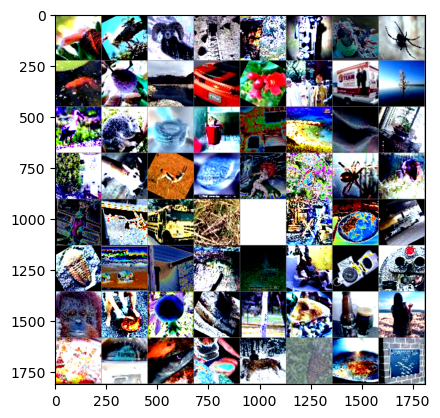

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# Model training

In [14]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 定义训练循环
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_accuracy = 100.0 * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)

        # 测试模式
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        test_accuracy = 100.0 * correct_test / total_test
        avg_test_loss = test_loss / len(test_loader)

        # 打印结果
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Train Accuracy: {train_accuracy:.2f}% | Test Loss: {avg_test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")


# 运行训练
num_epochs = 15
train(model, train_loader, test_loader, criterion, optimizer, num_epochs)


Epoch [1/15] Train Loss: 6.0387 Train Accuracy: 0.81% | Test Loss: 5.4027 Test Accuracy: 1.55%
Epoch [2/15] Train Loss: 5.3242 Train Accuracy: 1.48% | Test Loss: 5.0552 Test Accuracy: 2.70%
Epoch [3/15] Train Loss: 5.0231 Train Accuracy: 3.03% | Test Loss: 4.6554 Test Accuracy: 5.71%
Epoch [4/15] Train Loss: 4.7764 Train Accuracy: 4.68% | Test Loss: 4.5427 Test Accuracy: 6.26%
Epoch [5/15] Train Loss: 4.5721 Train Accuracy: 6.38% | Test Loss: 4.2789 Test Accuracy: 8.84%
Epoch [6/15] Train Loss: 4.3979 Train Accuracy: 8.30% | Test Loss: 4.0429 Test Accuracy: 11.68%
Epoch [7/15] Train Loss: 4.2415 Train Accuracy: 10.01% | Test Loss: 3.8226 Test Accuracy: 14.96%
Epoch [8/15] Train Loss: 4.0976 Train Accuracy: 11.88% | Test Loss: 3.8411 Test Accuracy: 14.92%
Epoch [9/15] Train Loss: 3.9675 Train Accuracy: 13.78% | Test Loss: 3.5723 Test Accuracy: 18.67%
Epoch [10/15] Train Loss: 3.8410 Train Accuracy: 15.42% | Test Loss: 3.4283 Test Accuracy: 20.99%
Epoch [11/15] Train Loss: 3.7311 Train A

# Model Result

In [15]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion': criterion,
            }, './model.pth')